# Import Libraries

In [1]:
from datasets import load_dataset, Dataset as hugging_dataset_cls
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Literal

# Import Data

In [2]:
# Load the emoji dataset
dataset = load_dataset("valhalla/emoji-dataset")

# Check the data
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2749
    })
})


# Plot Examples

In [3]:
# Parse features and labels
images = dataset['train']['image']
text = dataset['train']['text']


# Prepare Dataset

## Train Val Test Split

In [4]:
# NOTE if it ain't broke ...
fltr = lambda x: "face" in x['text'] and \
                "clock" not in x['text'] and \
                "woman" not in x['text'] and \
                "man" not in x['text'] and \
                "face palm" not in x['text'] and \
                "monkey face" not in x['text'] and \
                "dog face" not in x['text'] and \
                "wolf face" not in x['text'] and \
                "fox face" not in x['text'] and \
                "cat face" not in x['text'] and \
                "lion face" not in x['text'] and \
                "tiger face" not in x['text'] and \
                "horse face" not in x['text'] and \
                "unicorn face" not in x['text'] and \
                "zebra face" not in x['text'] and \
                "cow face" not in x['text'] and \
                "pig face" not in x['text'] and \
                "face throwing a kiss" not in x['text'] and \
                "giraffe face" not in x['text'] and \
                "mouse face" not in x['text'] and \
                "hamster face" not in x['text'] and \
                "rabbit face" not in x['text'] and \
                "bear face" not in x['text'] and \
                "panda face" not in x['text'] and \
                "frog face" not in x['text'] and \
                "dragon face" not in x['text'] and \
                "face massage" not in x['text'] and \
                "person with pouting face" not in x['text'] and \
                "face with no good gesture" not in x['text'] and \
                "face with ok gesture" not in x['text'] and \
                "new moon with face" not in x['text'] and \
                "first quarter moon with face" not in x['text'] and \
                "last quarter moon with face" not in x['text'] and \
                "full moon with face" not in x['text'] and \
                "sun with face" not in x['text'] and \
                "wind blowing face" not in x['text']

faces_dataset = dataset['train'].filter(fltr)
faces_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 90
})

The Filtered Dataset:


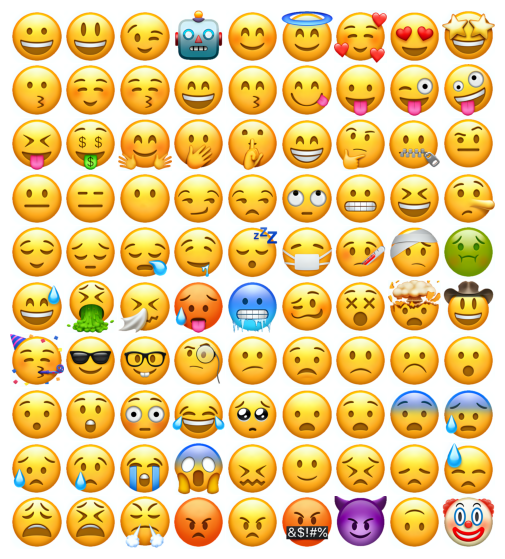

In [5]:


from mpl_toolkits.axes_grid1 import ImageGrid

filtered_images = faces_dataset['image']
filtered_text = faces_dataset['text']

fig = plt.figure(figsize=(7., 7.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 9),  # creates 2x2 grid of Axes
                 axes_pad=0.01,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, filtered_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')

print(f'The Filtered Dataset:')
plt.show()

## Augment Dataset
We augment the dataset by greating a hundred copies of each image, perturbed by Gaussian noise

Dataset({
    features: ['image', 'text'],
    num_rows: 450
})

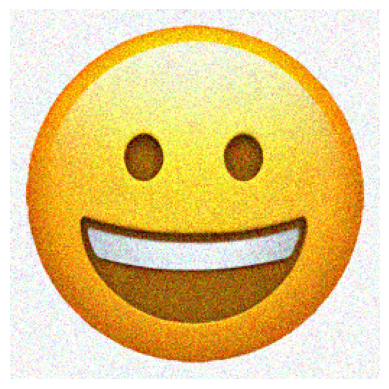

In [186]:
from torchvision.transforms import v2

to_tensor = transforms.ToTensor()
example_im = to_tensor(filtered_images[0]).permute(1,2,0)
noisify = v2.GaussianNoise()
plt.imshow(noisify(example_im))
plt.axis('off')
# plt.show()

temp1, temp2 = [], []
for im, text in zip(faces_dataset['image'], faces_dataset['text']):
    for _ in range(5):
        noisy_im = noisify(to_tensor(im))
        temp1.append(noisy_im)
        temp2.append(text)
# print(temp1)
augmented_dataset=  {'image':np.array(temp1), 'text':np.array(temp2)}
augmented_dataset = hugging_dataset_cls.from_dict(augmented_dataset)
augmented_dataset

In [173]:
def split(dataset):
    train_test = dataset.train_test_split(test_size=0.2)
    train_val = train_test['train'].train_test_split(test_size=0.25)
    dataset_split = {
        'train': train_val['train'],
        'val': train_val['test'],
        'test': train_test['test']
    }
    return dataset_split

# not augmented
# dataset_split = split(dataset = faces_dataset)

# augmented
dataset_split = split(dataset = augmented_dataset)

In [174]:
dataset_split['train']

Dataset({
    features: ['image', 'text'],
    num_rows: 270
})

## Create Custom Dataset

In [178]:
class EmojiDataset(Dataset):
    def __init__(self, data: hugging_dataset_cls):
        self.X = data['image']
        self.y = self.X
        # self.data = data
        # self.y = data['image']

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        to_tensor = transforms.ToTensor()
        # img_X = to_tensor(self.X[idx]).reshape(-1)
        # img_y = to_tensor(self.X[idx]).reshape(-1)
        img_X = to_tensor(self.X[idx])
        img_y = to_tensor(self.X[idx])
        return img_X, img_y

## Create Dataset Objects

In [183]:
type(dataset_split['train']['image'][0])

list

In [179]:
train_ds = EmojiDataset(dataset_split['train'])
val_ds = EmojiDataset(dataset_split['val'])
test_ds = EmojiDataset(dataset_split['test'])

## Batch into DataLoaders

In [180]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

for batch_X, batch_y in train_loader:
    print(batch_X.shape)
    print(batch_y.shape)
    break

TypeError: pic should be PIL Image or ndarray. Got <class 'list'>

# Create Autoencoder

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(256*256*3, 4096),
            nn.ReLU(),
            nn.Linear(4096, 512),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256*256*3),
            nn.Sigmoid()
        )

    def forward(self, X):
        x = self.encoder(X)
        return self.decoder(x)

# Train Model

## Create Trainer

In [13]:
class Trainer:
    def __init__(self, model: nn.Module, optimizer: optim.Optimizer, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, loss_fn: nn.MSELoss = nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.n_epochs = n_epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def train(self):
        train_losses, val_losses = [], []
        for epoch in range(1, self.n_epochs+1):
            print(f"Epoch {epoch}/{self.n_epochs}:")
            train_epoch_loss = self._train_single_epoch()
            val_epoch_loss = self._valid_single_epoch(self.val_loader)
            train_losses.append(train_epoch_loss)
            val_losses.append(val_epoch_loss)
            print("\n")

        return {
            "train_losses": train_losses,
            "val_losses": val_losses
        }
    
    def evaluate(self, loader_type: Literal['validation', 'test']) -> float:
        if loader_type == "test":
            loader = self.test_loader
        else:
            loader = self.val_loader

        return self._valid_single_epoch(loader, label=loader_type.capitalize())

    def _train_single_epoch(self) -> float:
        self.model.train()
        running_loss = 0.0
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
        for i, (input_data, output_data) in pbar:
            batch_num = i+1
            # Zero out grads
            self.optimizer.zero_grad()

            # Forward pass
            output = self.model(input_data)
            loss = self.loss_fn(output, output_data)
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Log
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg Train Loss: {avg_loss:.4f}")

        return avg_loss
    
    @torch.no_grad()
    def _valid_single_epoch(self, loader: DataLoader, label: str = "Validation") -> float:
        self.model.eval()
        running_loss = 0.0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for i, (input_data, output_data) in pbar:
            batch_num = i+1
            # Forward pass
            output = self.model(input_data)
            loss = self.loss_fn(output, output_data)
            running_loss += loss.item()

            # Log
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg {label} Loss: {avg_loss:.4f}")

        return avg_loss

## Train

In [14]:
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    n_epochs=10,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)

history = trainer.train()

KeyboardInterrupt: 

## Plot Training

In [ ]:
train_losses = history['train_losses']
val_losses = history['val_losses']
plt.title("Losses by Epoch")
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valdiation Loss')
plt.legend()
plt.show()

In [ ]:
@torch.no_grad()
def plot_input_output(model):
    for batch_X, batch_y in train_loader:
        test_im = batch_X[0]
        pred_test_im = model(test_im)

        test_im = torch.rot90(test_im.reshape(3,256,256), dims=(1,2))
        pred_test_im = torch.rot90(pred_test_im.reshape(3,256,256), dims=(1,2))

        render = torch.hstack((test_im, pred_test_im)).permute(2,1,0)

        plt.imshow(render)
        plt.title(f' Input                                     Output') # TODO excellent solution! never fix
        plt.axis("off")
        plt.show()
        break

plot_input_output(model=model)

## Try Convolutional Architecture

In [148]:
class AutoEncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),
            nn.Flatten(),
            nn.Linear(5408, 1024),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 5408),
            nn.Unflatten(1,(8,26,26)),
            nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5),
            nn.LeakyReLU(),
            nn.Upsample(size=(128, 128)),
            nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5),
            nn.LeakyReLU(),
            nn.Upsample(size=(200, 200)),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5),
            nn.LeakyReLU(),
            nn.Upsample(size=(256,256)),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, X):
        z = self.encoder(X)
        return self.decoder(z)

modelCNN = AutoEncoderCNN()
for batch_X, batch_y in train_loader_cnn:
    z = modelCNN.encoder(batch_X)
    # print(z)
    print(z.shape)
    y = modelCNN.decoder(z)
    # print(y)
    print(y.shape)

    break

torch.Size([8, 1024])
torch.Size([8, 196608])


In [139]:
class EmojiDataset(Dataset):
    def __init__(self, data: hugging_dataset_cls):
        self.data = data
        self.X = data['image']
        self.y = data['image']

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        to_tensor = transforms.ToTensor()
        img_X = to_tensor(self.X[idx])
        img_y = to_tensor(self.y[idx]).reshape(-1)
        return img_X, img_y

train_ds_cnn = EmojiDataset(dataset_split['train'])
val_ds_cnn = EmojiDataset(dataset_split['val'])
test_ds_cnn = EmojiDataset(dataset_split['test'])

train_loader_cnn = DataLoader(train_ds_cnn, batch_size=8, shuffle=True)
val_loader_cnn = DataLoader(val_ds_cnn, batch_size=8, shuffle=False)
test_loader_cnn = DataLoader(test_ds_cnn, batch_size=8, shuffle=False)

for batch_X, batch_y in train_loader_cnn:
    print(batch_X.shape)
    print(batch_y.shape)
    break


torch.Size([8, 3, 256, 256])
torch.Size([8, 196608])


In [149]:
optimizer = optim.Adam(modelCNN.parameters(), lr=1e-3)
trainer = Trainer(
    model=modelCNN,
    optimizer=optimizer,
    n_epochs=45,
    train_loader=train_loader_cnn,
    val_loader=val_loader_cnn,
    test_loader=test_loader_cnn
)

history_cnn = trainer.train()

Epoch 1/45:


Avg Validation Loss: 0.1049: 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]




Epoch 2/45:


Avg Validation Loss: 0.0777: 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]




Epoch 3/45:


Avg Validation Loss: 0.0651: 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]




Epoch 4/45:


Avg Validation Loss: 0.0581: 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]




Epoch 5/45:


Avg Validation Loss: 0.0547: 100%|██████████| 3/3 [00:00<00:00, 10.08it/s]




Epoch 6/45:


Avg Validation Loss: 0.0523: 100%|██████████| 3/3 [00:00<00:00,  9.96it/s]




Epoch 7/45:


Avg Validation Loss: 0.0502: 100%|██████████| 3/3 [00:00<00:00,  9.99it/s]




Epoch 8/45:


Avg Validation Loss: 0.0481: 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]




Epoch 9/45:


Avg Validation Loss: 0.0428: 100%|██████████| 3/3 [00:00<00:00,  9.56it/s]




Epoch 10/45:


Avg Validation Loss: 0.0402: 100%|██████████| 3/3 [00:00<00:00, 11.55it/s]




Epoch 11/45:


Avg Validation Loss: 0.0386: 100%|██████████| 3/3 [00:00<00:00, 11.97it/s]




Epoch 12/45:


Avg Validation Loss: 0.0381: 100%|██████████| 3/3 [00:00<00:00, 11.21it/s]




Epoch 13/45:


Avg Validation Loss: 0.0366: 100%|██████████| 3/3 [00:00<00:00, 11.46it/s]




Epoch 14/45:


Avg Validation Loss: 0.0361: 100%|██████████| 3/3 [00:00<00:00, 11.82it/s]




Epoch 15/45:


Avg Validation Loss: 0.0355: 100%|██████████| 3/3 [00:00<00:00, 10.92it/s]




Epoch 16/45:


Avg Validation Loss: 0.0365: 100%|██████████| 3/3 [00:00<00:00, 11.03it/s]




Epoch 17/45:


Avg Validation Loss: 0.0363: 100%|██████████| 3/3 [00:00<00:00, 11.43it/s]




Epoch 18/45:


Avg Validation Loss: 0.0347: 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]




Epoch 19/45:


Avg Validation Loss: 0.0352: 100%|██████████| 3/3 [00:00<00:00, 12.67it/s]




Epoch 20/45:


Avg Validation Loss: 0.0338: 100%|██████████| 3/3 [00:00<00:00, 11.95it/s]




Epoch 21/45:


Avg Validation Loss: 0.0340: 100%|██████████| 3/3 [00:00<00:00, 12.19it/s]




Epoch 22/45:


Avg Validation Loss: 0.0332: 100%|██████████| 3/3 [00:00<00:00, 12.90it/s]




Epoch 23/45:


Avg Validation Loss: 0.0334: 100%|██████████| 3/3 [00:00<00:00, 12.77it/s]




Epoch 24/45:


Avg Validation Loss: 0.0326: 100%|██████████| 3/3 [00:00<00:00, 12.65it/s]




Epoch 25/45:


Avg Validation Loss: 0.0340: 100%|██████████| 3/3 [00:00<00:00, 11.49it/s]




Epoch 26/45:


Avg Validation Loss: 0.0365: 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]




Epoch 27/45:


Avg Validation Loss: 0.0337: 100%|██████████| 3/3 [00:00<00:00, 12.60it/s]




Epoch 28/45:


Avg Validation Loss: 0.0334: 100%|██████████| 3/3 [00:00<00:00, 13.43it/s]




Epoch 29/45:


Avg Validation Loss: 0.0324: 100%|██████████| 3/3 [00:00<00:00, 13.18it/s]




Epoch 30/45:


Avg Validation Loss: 0.0322: 100%|██████████| 3/3 [00:00<00:00, 13.60it/s]




Epoch 31/45:


Avg Validation Loss: 0.0320: 100%|██████████| 3/3 [00:00<00:00, 11.69it/s]




Epoch 32/45:


Avg Validation Loss: 0.0317: 100%|██████████| 3/3 [00:00<00:00, 11.84it/s]




Epoch 33/45:


Avg Validation Loss: 0.0319: 100%|██████████| 3/3 [00:00<00:00, 11.49it/s]




Epoch 34/45:


Avg Validation Loss: 0.0313: 100%|██████████| 3/3 [00:00<00:00,  9.34it/s]




Epoch 35/45:


Avg Validation Loss: 0.0317: 100%|██████████| 3/3 [00:00<00:00, 10.80it/s]




Epoch 36/45:


Avg Validation Loss: 0.0310: 100%|██████████| 3/3 [00:00<00:00, 10.42it/s]




Epoch 37/45:


Avg Validation Loss: 0.0317: 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]




Epoch 38/45:


Avg Validation Loss: 0.0308: 100%|██████████| 3/3 [00:00<00:00, 10.18it/s]




Epoch 39/45:


Avg Validation Loss: 0.0309: 100%|██████████| 3/3 [00:00<00:00, 11.07it/s]




Epoch 40/45:


Avg Validation Loss: 0.0311: 100%|██████████| 3/3 [00:00<00:00, 11.22it/s]




Epoch 41/45:


Avg Validation Loss: 0.0314: 100%|██████████| 3/3 [00:00<00:00, 10.94it/s]




Epoch 42/45:


Avg Validation Loss: 0.0330: 100%|██████████| 3/3 [00:00<00:00, 11.88it/s]




Epoch 43/45:


Avg Validation Loss: 0.0316: 100%|██████████| 3/3 [00:00<00:00,  9.32it/s]




Epoch 44/45:


Avg Validation Loss: 0.0327: 100%|██████████| 3/3 [00:00<00:00, 11.63it/s]




Epoch 45/45:


Avg Validation Loss: 0.0309: 100%|██████████| 3/3 [00:00<00:00, 11.52it/s]

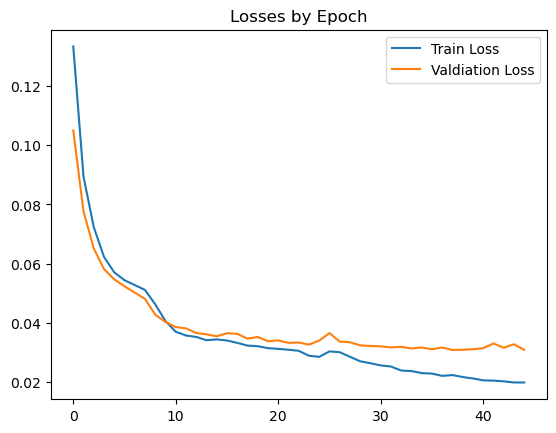

In [150]:
train_losses = history_cnn['train_losses']
val_losses = history_cnn['val_losses']
plt.title("Losses by Epoch")
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valdiation Loss')
plt.legend()
plt.show()

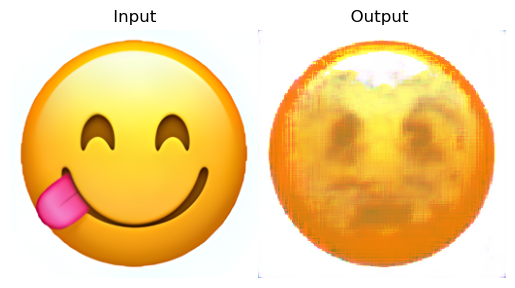

In [157]:
@torch.no_grad()
def plot_input_output(model):
    for batch_X, batch_y in val_loader_cnn:
        test_im = batch_X[0]
        pred_test_im = model(batch_X)[0]

        test_im = torch.rot90(test_im, dims=(1,2))
        pred_test_im = torch.rot90(pred_test_im.reshape(3,256,256), dims=(1,2))

        render = torch.hstack((test_im, pred_test_im)).permute(2,1,0)

        plt.imshow(render)
        plt.title(f' Input                                     Output') # TODO excellent solution! never fix
        plt.axis("off")
        plt.show()
        break

plot_input_output(model=modelCNN)